# NLP Basics: Wer redet da?

Hallo und herzlich willkommen zum codecentric.ai bootcamp!

In diesem Tutorial beschäftigen wir uns mit Grundlagen der automatischen Textanalyse (NLP).

Dazu haben wir einen Datensatz mit Reden deutscher Politiker ausgesucht und wollen ein Modell trainieren, das zu einer gegebenen Rede herausbekommt, wer sie gehalten hat! Trainiert wird das Modell mit Reden, zu denen es den Redner vorgesagt bekommt. Gemeinsam werden wir

1. den Datensatz von der Quelle herunterladen, inspizieren und bereinigen,
2. die Reden mit Hilfe der NLP-Bibliothek [spaCy](https://spacy.io) vorverarbeiten: tokenisieren, lemmatisieren und Begriffe extrahieren,
3. statistische Informationen wie _bag of words_ extrahieren, um jede Rede durch einen Vektor darzustellen, der als Eingabe für ein Klassifikationsmodell genutzt werden kann,
4. mit Hilfe der _machine learning_-Bibliothek [scikit-learn](https://sklearn.org) und der _deep learning_-Bibliothek [kerar](https://keras.io) verschiedene Modelle zur Klassifikation trainieren und
5. abschließend als Vorbereitung für einen tieferen Einstieg Worteinbettungen betrachten und für die Klassifikation der Reden verwenden.

Der folgende Screencast gibt einen kurzen Überblick über das Notebook.

Viel Spaß!

## Datensatz herunterladen, inspizieren und bereinigen

Unser Datensatz ist eine Sammlung von Reden, die Mitglieder der Bundesregierung beziehungsweise Bundespräsidenten gehalten haben, und wurde von Adrien Barbaresi zusammengestellt \[1\].

----

\[1\] Barbaresi, Adrien (2018). _A corpus of German political speeches from the 21st century._ Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018), European Language Resources Association (ELRA), pp. 792–797.

### Herunterladen und Entpacken

Wir laden den Datensatz (eine zip-Datei) mit [urllib](https://docs.python.org/3/library/urllib.html) herunter, entpacken ihn mit [zipfile](https://docs.python.org/3/library/zipfile.html), speichern die einzelnen Dateien lokal in dem Verzeichnis `DATA_PATH` und listen schließlich den Inhalt dieses Verzeichnisses auf.

*Achtung:* Das Herunterladen und Entpacken des Datensatzes (gepackt 26MB, entpackt 99MB) kann einen Moment dauern. Die eingebaute `if`-Abfrage dient dazu, ein wiederholtes Herunterladen zu vermeiden.

In [1]:
import os
import urllib
import zipfile

DATA_PATH = "data" # Zielordner für Download

def download_and_extract_data():
    SPEECHES_PATH = "http://adrien.barbaresi.eu/corpora/speeches/"
    SPEECHES_FILE = "German-political-speeches-2018-release.zip"
    SPEECHES_URL = SPEECHES_PATH + SPEECHES_FILE
    if not os.path.isdir(DATA_PATH):
        os.mkdir(DATA_PATH)
        zip_path = os.path.join(DATA_PATH, SPEECHES_FILE)
        urllib.request.urlretrieve(SPEECHES_URL, zip_path)
        with zipfile.ZipFile(zip_path) as file:
            file.extractall(path = DATA_PATH)

download_and_extract_data()
print("Entpackte Dateien:\n\t", "\n\t ".join(os.listdir(DATA_PATH)))

Entpackte Dateien:
	 AuswärtigesAmt.xml
	 stopwords_share_ez_no.txt
	 Bundestagspräsident.xml
	 Bundespräsidenten.pickle
	 stopwords_solariz.txt
	 Barbaresi_German-Political-speeches_LREC2018.pdf
	 Bundesregierung.xml
	 wiki.de.vec
	 Bundesregierung
	 Bundespräsidenten.xml
	 german.model
	 cc.de.300.vec
	 README.txt
	 stopwords_nltk.txt
	 German-political-speeches-2018-release.zip
	 LICENSE.txt
	 german_stopwords_plain.txt
	 Bundesregierung.pickle


### Einlesen und Inspizieren

Der Datensatz enthält mehrere XML-Dateien mit Sammlungen von Reden der Bundesregierung und der Bundespräsidenten. Wir konzentrieren uns auf erstere, extrahieren die Reden aus der XML-Datei mit [xmltodict](https://github.com/martinblech/xmltodict) und erstellen aus dem erhaltenen Python-Dictionary einen [pandas](https://pandas.pydata.org)-DataFrame.

In [2]:
import xmltodict
import numpy as np
import pandas as pd

DATASET = "Bundesregierung.xml"

def load_data():
    file = os.path.join(DATA_PATH, DATASET) 
    with open(file, mode="rb") as file:
        xml_document = xmltodict.parse(file)
        text_nodes = xml_document['collection']['text']
        persons = [t['@person'] for t in text_nodes]
        speeches = [t['rohtext']   for t in text_nodes]
        return pd.DataFrame({'person' : persons,
                             'speech' : speeches
        })

df = load_data()

Unser DataFrame `df` ist eine Tabelle mit zwei Spalten: `person` und `speech`. Jede Zeile enthält also in der ersten Spalte einen Redner und in der zweiten eine Rede, beides jeweils als Python-String. Schauen wir uns den DataFrame genauer an: die Methode
- `head()` zeigt uns die ersten zehn Zeilen der Tabelle,
- `value_counts()` zählt für jeden Redner, wie oft er in der Spalte auftaucht.

In [3]:
df.head()
df.person.value_counts()

Angela Merkel              1125
Gerhard Schröder            418
Bernd Neumann               323
Monika Grütters             245
Christina Weiss             203
k.A.                         88
Michael Naumann              61
Julian Nida-Rümelin          47
Thomas de Maizière           43
Hans Martin Bury             42
Joschka Fischer              31
Rolf Schwanitz               24
Frank-Walter Steinmeier       7
Andere                        4
Jullian Nida-Rümelin          1
Name: person, dtype: int64

Als nächstes verschaffen uns einen Überblick darüber, wie lang die Reden von jedem Redner sind. Dazu

- fügen wir unserem DataFrame `df` eine neue Spalte hinzu, welche die jeweilige Länge der Rede enthält, und
- erstellen mit Hilfe von [seaborn](https://seaborn.pydata.org/) einen [Boxplot](https://de.wikipedia.org/wiki/Box-Plot), der die Verteilung der Redenlängen pro Redner übersichtlich darstellt.

Im Hintergrund verwendet seaborn die Bibliothek [matplotlib](https://matplotlib.org), die detaillierte Feineinstellungen ermöglicht.

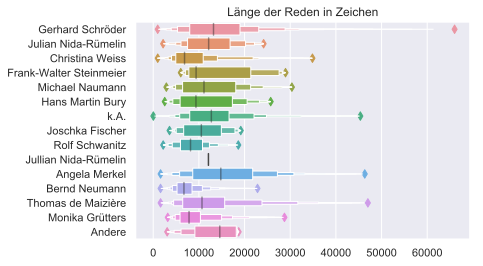

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # schönere Grafiken
sns.set()

df["length"] = df.speech.str.len()
_ = sns.boxenplot(y="person", x="length", data=df) \
       .set(title="Länge der Reden in Zeichen", xlabel="", ylabel="")

### Bereinigen

Oft beherbergt ein Datensatz Fehler oder Unvollständigkeiten. In der Tabelle der Redenanzahl sehen wir, dass Julian Nida-Rümelins Name einmal falsch geschrieben wurde. Außerdem ist für einige Reden kein Redner angegeben, sondern "k.A." oder "Andere". Wir korrigieren den Namen und entfernen alle Reden ohne Redner.

In [5]:
df['person'] = df.person.str.replace("Jullian Nida-Rümelin", "Julian Nida-Rümelin")
df = df.query("person not in ['k.A.', 'Andere']")
df.person.value_counts()

Angela Merkel              1125
Gerhard Schröder            418
Bernd Neumann               323
Monika Grütters             245
Christina Weiss             203
Michael Naumann              61
Julian Nida-Rümelin          48
Thomas de Maizière           43
Hans Martin Bury             42
Joschka Fischer              31
Rolf Schwanitz               24
Frank-Walter Steinmeier       7
Name: person, dtype: int64

Zudem haben wir gesehen, dass der Datensatz sehr unausgewogen ist. Insbesondere Angela Merkel ist mit überproportional vielen Reden repräsentiert. Das birgt die Gefahr, dass das Modell lernt, dass viele Reden von ihr stammen, und entsprechend oft Frau Merkel voraussagt.

Wir wirken dem Problem entgegen, indem wir pro Redner jeweils nur eine begrenzte Anzahl von Reden erlauben und diese zufällig auswählen. Danach kontrollieren wir die Anzahl noch einmal mit einem Balkendiagramm.

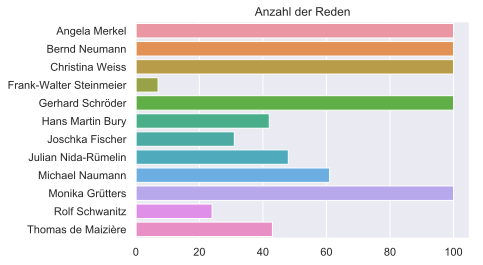

In [6]:
MAX_SPEECHES = 100

def limit_speeches_per_person(df):
    def sample_speeches(group):
        return group.sample(min(len(group), MAX_SPEECHES))

    return df.groupby("person", group_keys = False) \
             .apply(sample_speeches) \
             .reset_index(drop = True)

df = limit_speeches_per_person(df)
_ = sns.countplot(y="person", data=df) \
       .set(title="Anzahl der Reden", xlabel="", ylabel="")

## Analyse der Reden &mdash; von Daten zu Features

Die Reden liegen uns nun als Python-Strings vor. Zur Anwendung von machine learning oder deep learning müssen wir sie nun mit Hilfe von NLP weiterverarbeiten. Dafür gibt es zahlreiche Python-Bibliotheken wie

- [NLTK](https://www.nltk.org/) ("the natural language toolkit"),
- [spaCy](https://spacy.io/) ("industrial strength natural language processing"),
- [gensim](https://radimrehurek.com/gensim/) ("topic modelling for humans")

und viele andere. Wir verwenden in diesem Tutorial spaCy.

### Automatische Textanalyse mit spaCy 

Als Erstes benötigt spaCy ein "Modell" der Sprache, mit der es arbeiten soll. Dieses Modell enthält statistische Informationen über die Sprache und wird für Deutsch von spaCy bereitgestellt.

In [7]:
import spacy
nlp = spacy.load("de_core_news_sm")

Rufen wir  `nlp` mit einem Python-String auf, so wendet spaCy seine [Textanalyse-Pipeline](https://spacy.io/usage/processing-pipelines) darauf an und

1. zerlegt den Text in _Token_ ([Tokenisierung](https://de.wikipedia.org/wiki/Tokenisierung)),
2. bestimmt die Wortstämme beziehungsweise Grundformen der Token ([Lemmatisierung](https://de.wikipedia.org/wiki/Lemma_(Lexikographie)#Lemmatisierung)),
3. bestimmt die Wortart ([part-of-speech tagging](https://de.wikipedia.org/wiki/Part-of-speech-Tagging),
4. analysiert die grammatikalische Struktur der Text und
5. extrahiert Begriffe ([named entity recognition](https://de.wikipedia.org/wiki/Part-of-speech-Tagging)).

Schauen wir uns die Ergebnisse der Schritte 1-3 für einen Beispielsatz an:

In [8]:
document = nlp("Peter fährt in Berlin am schnellsten auf dem kaputten kunterbunten Fahrrad.")
pd.DataFrame({"Token": [word.text for word in document],
              "Grundform": [word.lemma_ for word in document],
              "Wortart": [word.pos_ for word in document]})

,Token,Grundform,Wortart
0,Peter,Peter,PROPN
1,fährt,fahren,VERB
2,in,in,ADP
3,Berlin,Berlin,PROPN
4,am,am,PART
5,schnellsten,schnell,ADJ
6,auf,auf,ADP
7,dem,der,DET
8,kaputten,kaputt,ADJ
9,kunterbunten,kunterbunten,ADJ


Wir sehen, dass Schritt 2 nicht immer korrekte Ergebnisse liefert. Grund dafür ist z.B., dass das Modell nicht alle Wörter kennt. Außerdem verwendet spaCy selbst nicht eine Sammlung von Regeln, sondern neuronale Netze mit entsprechend unscharfen Ergebnissen.

### Anwendung auf die Reden

Nun wenden wir spaCy auf unsere Reden an und

- extrahieren die jeweiligen Folgen von Token, Grundformen und Begriffen,
- schalten dabei nicht benutzte Pipeline-Schritte wie die grammatikalische Analyse ab,
- tragen die Ergebnisse in neue Spalten in unserem DataFrame 'df' ein.

Weil das eine Weile dauert, speichern wir die Ergebnisse mittels [pickle](https://docs.python.org/3/library/pickle.html) ab und lesen sie das nächste Mal einfach wieder ein. Zeit für einen Kaffee?

In [9]:
ANALYSIS_FILE = DATASET.replace(".xml", ".pickle")
ANALYSIS_PATH = os.path.join(DATA_PATH, ANALYSIS_FILE)

def analyze(speech):
    with nlp.disable_pipes("tagger", "parser"):
        document = nlp(speech)
        token = [w.text for w in document]
        lemma = [w.lemma_ for w in document]
        entities = [e.text for e in document.ents]
        return (token, lemma, entities)
    
if not os.path.isfile(ANALYSIS_PATH):
    df["analysis"] = df.speech.map(analyze)
    df["tokens"] = df.analysis.apply(lambda x: x[0])
    df["lemmata"] = df.analysis.apply(lambda x: x[1])
    df["entities"] = df.analysis.apply(lambda x: x[2])
    df.to_pickle(ANALYSIS_PATH)
else:
    df = pd.read_pickle(ANALYSIS_PATH)

Unser DataFrame sieht nun wie folgt aus:

In [10]:
df.head()

,person,speech,length in chars,analysis,tokens,lemmata,entities
0,Angela Merkel,"Sehr geehrter Herr Ministerpräsident,\nsehr ge...",11969,"([Sehr, geehrter, Herr, Ministerpräsident, ,, ...","[Sehr, geehrter, Herr, Ministerpräsident, ,, \...","[Sehr, geehrt, Herr, Ministerpräsident, ,, \n,...","[\n, \n, \n, Deutsch-Ägyptischen Wirtschaftsfo..."
1,Angela Merkel,"ich freue mich, heute wieder hier zu sein. Ich...",7104,"([ich, freue, mich, ,, heute, wieder, hier, zu...","[ich, freue, mich, ,, heute, wieder, hier, zu,...","[ich, freuen, sich, ,, heute, wieder, hier, zu...","[Herrn Zwanziger, Wotan, Frauen-Fußballweltmei..."
2,Angela Merkel,"Ich bin, lieber Herr Doğan, das darf ich aus Ü...",12549,"([Ich, bin, ,, lieber, Herr, Doğan, ,, das, da...","[Ich, bin, ,, lieber, Herr, Doğan, ,, das, dar...","[ich, sein, ,, lieb, Herr, Doğan, ,, der, dürf...","[Ich bin, Doğan, Mörfelden, Euro D, Berlin, Eu..."
3,Angela Merkel,"Sehr geehrter Herr Bundesminister, lieber Karl...",25879,"([Sehr, geehrter, Herr, Bundesminister, ,, lie...","[Sehr, geehrter, Herr, Bundesminister, ,, lieb...","[Sehr, geehrt, Herr, Bundesminister, ,, lieb, ...","[Bundesminister, Karl-Theodor zu Guttenberg, \..."
4,Angela Merkel,"In Frankfurt am Main\nSehr geehrter Wetzel,\nH...",24943,"([In, Frankfurt, am, Main, \n, Sehr, geehrter,...","[In, Frankfurt, am, Main, \n, Sehr, geehrter, ...","[In, Frankfurt, am, Main, \n, Sehr, geehrt, We...","[Frankfurt am Main, \nHerr Huber, \nHerr Somme..."


###  Von Token zu Statistiken

Die mit spaCy analysierten Reden verarbeiten wir jetzt weiter, indem wir

1. das _Gesamt-Vokabular_ bestimmen, also die Menge aller Token, die in den Reden verwendet werden;
2. das Gesamt-Vokabular durchnummerieren und ein Python-Dictionary `word2index` anlegen, das jedem Token seine Nummer zuordnet;
3. für jede Rede  ermitteln, _welche_  Token darin auftauchen (die Menge ist das _bag of words_ der Rede) und _wie oft_ jedes Token darin auftaucht.

Dasselbe machen wir auch für die _Grundformen_ der Token und die _extrahierten Begriffe_. Weitere interessante statistische Informationen wären etwa die _relative Häufigkeit_ oder das [tf-idf-Maß](https://de.wikipedia.org/wiki/Tf-idf-Ma%C3%9F) der Token.

Dafür gibt es natürlich bereits fertige [Routinen](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text) in Bibliotheken wie [scikit-learn](https://sklearn.org). Aber erstens können wir diese Schritte einfach selbst bewältigen, und zweitens lernt man dabei mehr!

In [11]:
def bag_of_words(speeches):
    word_sets = [set(speech) for speech in speeches]
    all_words = set.union(*word_sets)
    word2index = {word: index for (index, word) in enumerate(all_words)}
    indexed_speeches = speeches.apply(lambda speech: [word2index[word]
                                                      for word in speech])
    return (indexed_speeches, word2index)

Ein Beispiel macht klarer, was passiert:

In [12]:
example = pd.DataFrame({"Rede": [\
    ["Hallo", "Welt", "Du", "bist", "so", "schön"], \
    ["Hallo", "bist", "Du", "wach", "Du"], \
    ["die", "Welt", "ist", "groß", "ist", "die", "Welt"]]}, index=["","",""])

example["Bag of Words"], example_index =  bag_of_words(example.Rede)
pd.DataFrame(example_index, index=[""])

,so,Welt,schön,groß,Hallo,die,bist,ist,Du,wach
,0,1,2,3,4,5,6,7,8,9


In [13]:
example

,Rede,Bag of Words
,"[Hallo, Welt, Du, bist, so, schön]","[4, 1, 8, 6, 0, 2]"
,"[Hallo, bist, Du, wach, Du]","[4, 6, 8, 9, 8]"
,"[die, Welt, ist, groß, ist, die, Welt]","[5, 1, 7, 3, 7, 5, 1]"


Als zweite Variante zählen wir für jedes Token einer Rede, wie oft es in der Rede auftritt &mdash; daher die Bezeichnung `count`. Dafür ist die Klasse [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) hilfreich.

In [14]:
from collections import Counter

def count_words(speeches, word2index):
    def count_speech(speech):
        return {word2index[word]: count
                for (word, count) in Counter(speech).items()}
    return speeches.apply(count_speech)

example["Counts"] = count_words(example["Rede"], example_index)
example

,Rede,Bag of Words,Counts
,"[Hallo, Welt, Du, bist, so, schön]","[4, 1, 8, 6, 0, 2]","{4: 1, 1: 1, 8: 1, 6: 1, 0: 1, 2: 1}"
,"[Hallo, bist, Du, wach, Du]","[4, 6, 8, 9, 8]","{4: 1, 6: 1, 8: 2, 9: 1}"
,"[die, Welt, ist, groß, ist, die, Welt]","[5, 1, 7, 3, 7, 5, 1]","{5: 2, 1: 2, 7: 2, 3: 1}"


Für eine einheitliche Weiterverarbeitung wandeln wir die bags-of-words ebenfalls in Dictionarys um, die jedem Token einfach eine 1 zuordnen.

In [15]:
def bags_of_words_to_dicts(bags_of_words):
    return bags_of_words.apply(lambda bow: {word: 1 for word in bow})

example["Bag of Words as dict"] = bags_of_words_to_dicts(example["Bag of Words"])
example

,Rede,Bag of Words,Counts,Bag of Words as dict
,"[Hallo, Welt, Du, bist, so, schön]","[4, 1, 8, 6, 0, 2]","{4: 1, 1: 1, 8: 1, 6: 1, 0: 1, 2: 1}","{4: 1, 1: 1, 8: 1, 6: 1, 0: 1, 2: 1}"
,"[Hallo, bist, Du, wach, Du]","[4, 6, 8, 9, 8]","{4: 1, 6: 1, 8: 2, 9: 1}","{4: 1, 6: 1, 8: 1, 9: 1}"
,"[die, Welt, ist, groß, ist, die, Welt]","[5, 1, 7, 3, 7, 5, 1]","{5: 2, 1: 2, 7: 2, 3: 1}","{5: 1, 1: 1, 7: 1, 3: 1}"


Wir wenden all das nun auf unsere Reden an und verwenden dabei nicht nur die Token, sondern auch deren Grundformen und die extrahierten Begriffe. Die Ergebnisse tragen wir wieder in unseren DataFrame `df` in neue Spalten ein. 

In [16]:
PARTS = ["tokens", "lemmata", "entities"]
INDEX = dict()

for part in PARTS:
    (bow, INDEX[part]) = bag_of_words(df[part])
    df[part + "_bow"] = bags_of_words_to_dicts(bow)
    df[part + "_count"] = count_words(df[part], INDEX[part])

Exemplarisch betrachten wir einige der extrahierten Daten der ersten Rede.

In [17]:
df.iloc[0]

person                                                 Angela Merkel
speech             Sehr geehrter Herr Ministerpräsident,\nsehr ge...
length in chars                                                11969
analysis           ([Sehr, geehrter, Herr, Ministerpräsident, ,, ...
tokens             [Sehr, geehrter, Herr, Ministerpräsident, ,, \...
lemmata            [Sehr, geehrt, Herr, Ministerpräsident, ,, \n,...
entities           [\n, \n, \n, Deutsch-Ägyptischen Wirtschaftsfo...
tokens_bow         {32444: 1, 25061: 1, 42109: 1, 29078: 1, 6453:...
tokens_count       {32444: 1, 25061: 1, 42109: 4, 29078: 4, 6453:...
lemmata_bow        {26074: 1, 37504: 1, 33841: 1, 23379: 1, 5204:...
lemmata_count      {26074: 1, 37504: 4, 33841: 4, 23379: 4, 5204:...
entities_bow       {10640: 1, 10744: 1, 19687: 1, 4296: 1, 12229:...
entities_count     {10640: 15, 10744: 2, 19687: 1, 4296: 2, 12229...
Name: 0, dtype: object

## Klassifikation der Reden mit machine learning und scikit-learn

Wir trainieren nun ein Modell darauf, zu einer gegebenen Rede den jeweiligen Redner zu bestimmen! Dazu verwenden wir

- als "Fingerabdruck" jeder Rede die extrahierten statistischen Informationen und
- als Modell zuerst ein klassisches _machine learning_-Verfahren, einen [Bayes-Klassifikator](https://de.wikipedia.org/wiki/Bayes-Klassifikator),
- die Standard-machine learning-Bibliothek [scikit-learn](https://sklearn.org).

### Vorbereitung

Obwohl wir die Daten bereits aufbereitet haben, sind für das Training und das Testen des Modells noch ein paar Vorbereitungen erforderlich.

Um zu sehen, welchen Einfluss die Datenmenge und -auswahl auf die Genauigkeit der Klassifikation hat, wählen wir zunächst mit `sample_speeches` pro Redner eine feste Anzahl `num_samples`von Reden zufällig aus dem Datensatz `data` aus. Sind nicht genügend Reden vorhanden, wird der Redner herausgefiltert.

In [18]:
NO_SAMPLES = 0

def sample_speeches(data, num_samples):
    # lokale Hilfsfunktion, führt Sampling und Entfernung von Personen aus
    def sample(group):
        if len(group) >= num_samples:
            return group.sample(num_samples)
        else:
            return group.sample(NO_SAMPLES)
    return data.groupby("person", group_keys=False).apply(sample).reset_index(drop=True)

# beispielhaftes Sampling
sampled_df = sample_speeches(df, 20)
sampled_df["person"].value_counts()

Rolf Schwanitz         20
Bernd Neumann          20
Thomas de Maizière     20
Angela Merkel          20
Monika Grütters        20
Michael Naumann        20
Julian Nida-Rümelin    20
Gerhard Schröder       20
Christina Weiss        20
Hans Martin Bury       20
Joschka Fischer        20
Name: person, dtype: int64

Als nächstes zerlegen wir mit `split` die aufbereiteten Daten `data` &mdash; die Fingerabdrücke der Reden &mdash; und die zugehörigen `label` &mdash; die Liste der jeweiligen Redner &mdash; im Verhältnis `ratio` zu 1-`ratio` in ein Trainings-Daten und Test-Daten. Dabei erfolgt die Auswahl zufällig und die Daten werden permutiert.

In [19]:
def split(data, labels, ratio):
    size = data.shape[0]
    split_index = int(ratio * size)
    indices = np.random.permutation(size)
    train_indices, test_indices = (indices[:split_index], indices[split_index:])
    return (data[train_indices], labels[train_indices],
            data[test_indices], labels[test_indices])

# beispielhaftes Zerlegen, sodass zwei Trainingsdatenpunkte entstehen
train_word, train_label, test_word, test_label = split(pd.Series(["Das", "ist", "ein", "Test"]), 
                                                       pd.Series([1, 2, 3, 4]), 0.6)
train_word

2     ein
3    Test
dtype: object

Für jede Rede haben wir bisher die statistischen Informationen in Python-Dictionarys abgelegt. Der Bayes-Klassifikator benötigt diese Daten aber in Form eines zweidimensionalen Arrays, bei dem jede Zeile einer Rede entspricht, jede Spalte einem Token (bzw. Grundform oder Begriff) des Gesamtvokabulars. Da das Gesamtvokabular sehr groß ist, in jeder Rede aber davon nur ein sehr kleiner Bruchteil verwendet wird, würde dieses Array hauptsächlich Nullen enthalten. Das Modul
[scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) bietet für solche [dünn besetzten](https://de.wikipedia.org/wiki/D%C3%BCnnbesetzte_Matrix) Arrays speziell optimierte Datenstrukturen.
Mit `dict_to_sparse` wandeln wir nun eine Liste der Python-Dictionarys in eine dünn besetzte Matrix um.

In [20]:
import scipy.sparse as sparse
import itertools

def dict_to_sparse(list_of_dicts, vocab_size):
    index_and_data = [(index, dictionary[index])  for dictionary in list_of_dicts 
                          for index in dictionary]
    index, data = zip(*index_and_data)
    lens = [len(dictionary) for dictionary in list_of_dicts]
    row_pointers = list(itertools.accumulate([0] + lens))
    return sparse.csr_matrix((data, index, row_pointers), 
                             shape=(len(list_of_dicts), vocab_size))

In [21]:
dict_to_sparse(example["Bag of Words as dict"], len(example_index)).toarray()

array([[1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0]])

### Training und Test des Modells

Training und Test des Bayes-Klassifikators kapseln wir in eine separate Routine `train_and_test`. Neben den Daten und Labels erwartet diese als Parameter auch das zu wählende Verhältnis zwischen Trainingsdaten und Testdaten.
Die Methode `fit` führt das eigentliche Training durch und die Methode `predict` den Test. Die Genauigkeit des Modells messen wir wie folgt:

- `accuracy` gibt an, welcher Anteil der Vorhersagen korrekt war, ist also ein einfaches Maß für die Genauigkeit;
- `confusion` ist eine Matrix, deren Zeilen und Spalten mit den vorhandenen Rednern durchnummeriert sind und deren i-te Zeile und j-te Spalte angibt, wieviel Reden des i-ten Redners von dem Modell für eine Rede des j-ten Redners gehalten wurden.

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

def train_and_test(data, labels, split_ratio):
    train_data, train_labels, test_data, test_labels = split(data, labels,
                                                             split_ratio)
    classifier = MultinomialNB()
    classifier.fit(train_data, train_labels)
    predictions = classifier.predict(test_data)
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    return (accuracy, confusion)

### Das Experiment

Nun kommen wir zum eigentlichen Experiment! Wir trainieren und testen nacheinander und unabhängig voneinander einen Bayes-Klassifikator mit den extrahierten statistischen Informationen und machen für jede Kombination von
Features und Statistiken mehrere Durchläufe. Anschließend visualisieren wir die Ergebnisse.

In [23]:
FEATURES = ["tokens", "lemmata", "entities"]
STATS = ["bow", "count"]
REPETITIONS = 40
SPLIT_RATIO = 0.7
NUM_SAMPLES = 80

def bayes_experiment(features=FEATURES, stats=STATS, repetitions=REPETITIONS,
                     num_samples=NUM_SAMPLES, split_ratio=SPLIT_RATIO):
    sampled_df = sample_speeches(df, num_samples)
    labels = sampled_df["person"].astype("category").cat.codes
    results = []
    for feature in features:
        for stat in stats:
            data = dict_to_sparse(sampled_df[feature + "_" + stat],
                                  len(INDEX[feature]))
            print("Klassifizierung anhand Statistik '%s' für Feature '%s'" 
                  % (stat, feature))
            for i in range(0, repetitions):
                (accuracy, confusion) = train_and_test(data, labels, split_ratio)
                results.append({"feature": feature, 
                                "stat": stat, 
                                "repetition": i,
                                "accuracy": accuracy, 
                                "confusion_matrix": confusion})
    return pd.DataFrame(results)

Wir führen das Experiment zuerst mit 40 Reden pro Person durch.

In [24]:
results_few_samples = bayes_experiment(num_samples = 40)
results_few_samples.groupby(["feature", "stat"])["accuracy"].mean().unstack()

Klassifizierung anhand Statistik 'bow' für Feature 'tokens'
Klassifizierung anhand Statistik 'count' für Feature 'tokens'
Klassifizierung anhand Statistik 'bow' für Feature 'lemmata'
Klassifizierung anhand Statistik 'count' für Feature 'lemmata'
Klassifizierung anhand Statistik 'bow' für Feature 'entities'
Klassifizierung anhand Statistik 'count' für Feature 'entities'


stat,bow,count
feature,,
entities,0.538303,0.438303
lemmata,0.461697,0.423853
tokens,0.455046,0.375229


Folgender Plot zeigt, dass die Genauigkeit der Vorhersage stark von der zufälligen Auswahl der Reden abhängt.

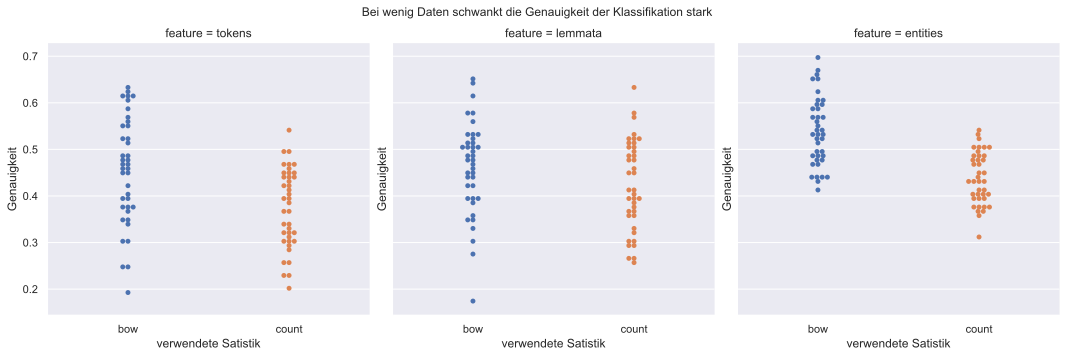

In [25]:
def plot_accuracies(data, title):
    sns.catplot(data=data, col="feature", x="stat", y="accuracy", kind="swarm") \
        .set(xlabel="verwendete Satistik", ylabel="Genauigkeit")
    plt.subplots_adjust(top=0.88)
    plt.suptitle(title)
    
plot_accuracies(results_few_samples, "Bei wenig Daten schwankt die Genauigkeit der Klassifikation stark")

Als nächstes plotten wir heatmaps für die  [Konfusionsmatrizen](https://en.wikipedia.org/wiki/Confusion_matrix). Wie bereits erklärt geben diese an, wieviel Reden richtig (Diagonaleinträge) beziehungsweise falsch (die anderen Einträge) zugeordnet wurden. Wir gruppieren diese Matrizen nach Feature und Statistik und summieren über die Durchläufe auf.

So zeigt sich, dass zum Beispiel für die Features Lemmata und Tokens (die beiden rechten Spalten) ein bis zwei Redner bevorzugt vorausgesagt wurden ("helle" Spalten).

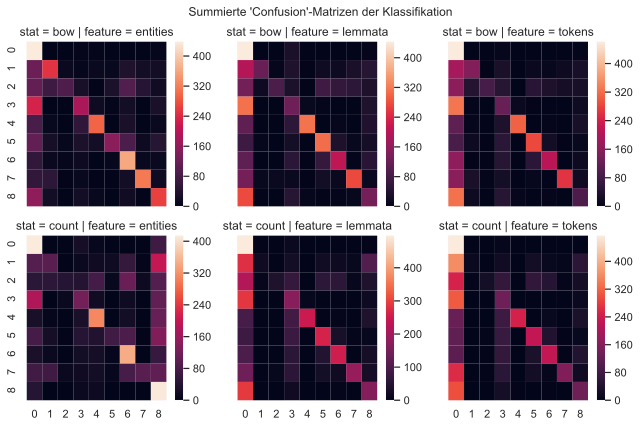

In [26]:
def plot_confusion_matrices(results):
    def plot_heatmap(data, **kwargs):
        sns.heatmap(data["confusion_matrix"].iloc[0])
    confusion_matrix = results.groupby(["feature", "stat"])["confusion_matrix"] \
                              .apply(lambda cms: np.sum(cms, axis=0)) \
                              .reset_index()   
    g = sns.FacetGrid(confusion_matrix, col="feature", row="stat")
    g.map_dataframe(plot_heatmap)
    plt.subplots_adjust(top=0.9)
    plt.suptitle("Summierte 'Confusion'-Matrizen der Klassifikation")

plot_confusion_matrices(results_few_samples)

Nun führen wir dasselbe Experiment noch einmal mit 100 Reden pro Person durch und schauen, wie sich die Vorhersagegenauigkeit verbessert.

In [27]:
results_many_samples = bayes_experiment(num_samples=100)
results_many_samples.groupby(["feature", "stat"])["accuracy"].mean().unstack()

Klassifizierung anhand Statistik 'bow' für Feature 'tokens'
Klassifizierung anhand Statistik 'count' für Feature 'tokens'
Klassifizierung anhand Statistik 'bow' für Feature 'lemmata'
Klassifizierung anhand Statistik 'count' für Feature 'lemmata'
Klassifizierung anhand Statistik 'bow' für Feature 'entities'
Klassifizierung anhand Statistik 'count' für Feature 'entities'


stat,bow,count
feature,,
entities,0.739833,0.6810
lemmata,0.821667,0.8085
tokens,0.818167,0.8110


Die Voraussagekraft steigt nicht nur an, auch sind die Ergebnisse der Wiederholungen konzentrierter:

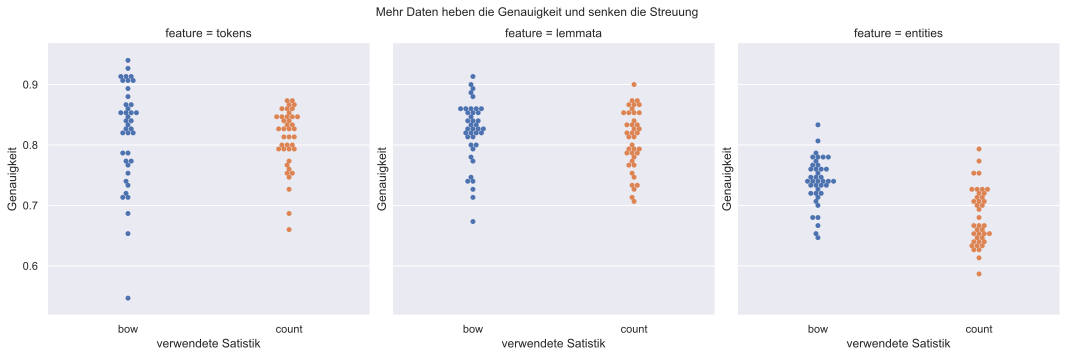

In [28]:
plot_accuracies(results_many_samples, "Mehr Daten heben die Genauigkeit und senken die Streuung")

## Klassifikation mit einem neuronalen Netz

Nun tauschen wir den Bayes-Klassifikator gegen ein neuronales Netz aus. Wir nutzen dazu die deep learning-Bibliothek [keras](https://keras.io) und wählen ein einfache Netz-Architektur: mehrere sequentiell aufeinander folgenden Schichten von Neuronen. Die dafür benötigte Funktionalität stellt `keras` mit der Modell-Klasse `Sequential` und dem Untermodul `layers`bereit.

In [29]:
from keras.models import Sequential
from keras import layers

Using plaidml.keras.backend backend.


### Die Architektur des neuronalen Netzes

Als *Eingabe* für unser Netz verwenden wir dieselben Daten wie zuvor: jede Rede wird durch einen Vektor dargestellt, dessen i-te Komponente eine statistische Größe für das i-te Token des Gesamtvokabulars enthält. Dieser Eingabevektor wird von einer *ersten Schicht von Neuronen* aufgegriffen. Jedes Neuron dieser Schicht 
  * wichtet die Komponenten des Eingabevektors mit Gewichten, die das Neuron in der Trainingsphase optimiert,
  * bildet anschließend die Summe der gewichteten Komponeten und 
  * wendet auf die Summe eine _Aktivierungsfunktion_ an, hier [`relu`](https://de.wikipedia.org/wiki/Rectifier_(neuronale_Netzwerke)). 

Die Werte dieser Aktivierungsfunktionen bilden den Ausgabevektor der ersten Schicht. Die Ausgabe der ersten Schicht dient als Eingabe für *eine zweite Schicht* von Neuronen, die nach demselben Prinzip ihrerseits einen Ausgabevektor bildet. Solche dicht vernetzten Schichten können wir nun munter aufeinanderstapeln.

Als *Ausgabe* soll uns das Netz sagen, von welchem Politiker die Rede stammt. Dafür  verwenden wir eine Schicht mit genau soviel Neuronen, wie Politiker auftreten: das i-te Neuron gibt uns die vom Netz vermutete Wahrscheinlichkeit dafür an, dass die Rede von dem i-ten Politiker stammt. Diese Wahrscheinlichkeiten müssen sich zu 1 aufsummieren. Das sichern wir mit Hilfe der Aktivierungsfunktion [softmax](https://de.wikipedia.org/wiki/Softmax-Funktion).

Den Aufbau des Netzes übernimmt die folgende Funktion `build_seq_model`. Ihre Parameter sind
- `x_dim` - die Dimension des Eingabevektors (Größe des Vokabulars),
- `y_dim` - die Dimension des Ausgabevektors (Anzahl der Politiker) und
- `architecture` - die Anzahl der Neuronen von der ersten bis zur vorletzten Schicht (beziehungsweise die [Dropout-Rate](https://de.wikipedia.org/wiki/Dropout_(k%C3%BCnstliches_neuronales_Netz)), die erst später relevant wird).

Bevor wir das Netz trainieren können, muss es noch kompiliert werden. Dazu ist eine Loss-Funktion anzugeben, welche Keras während des Trainings mit dem angegebenen Optimierer zu minimieren versucht. Da die Ausgabe des Netzes eine Wahrscheinlichkeitsverteilung für die gegebenen Politiker ist, wählen wir hier die [Kreuzentropie](https://de.wikipedia.org/wiki/Kreuzentropie).

In [30]:
from keras.optimizers import RMSprop, Adam
from sklearn.metrics import confusion_matrix

def build_seq_model(x_dim, y_dim, architecture):
    model = Sequential()
    model.add(layers.Dense(architecture[0], input_shape=(x_dim,),
                           activation='relu'))
    for s in architecture[1:]:
        if s >= 1:
            model.add(layers.Dense(s, activation='relu'))
        else:
            # dieser Fall wird erst später genutzt, erstmal ignorieren!
            model.add(layers.Dropout(rate=s))
    model.add(layers.Dense(y_dim, activation="softmax"))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy')
    return model

### Training und Test des Netzes

Bevor wir das Netz trainieren können, müssen wir uns noch über die Labels Gedanken machen: Während der Bayes-Klassifikator erwartet hat, dass wir die Politiker durchnummerieren, benötigt unser neuronales Netz für Label dasselbe Format, was es auch ausgibt: Wahrscheinlichkeitsverteilungen. Genauer gesagt müssen wir unsere Politiker [one-hot-encoden](https://de.wikipedia.org/wiki/1-aus-n-Code): ist die Rede vom i-ten Politiker, so ist das zugehörige Label der Vektor, der an der i-ten Stelle eine 1 und für alle anderen Politiker eine 0 enthält. Das geht mit folgendem `numpy`-Trick:

In [31]:
def one_hot_encode(y):
    dim = np.max(y) + 1
    return np.eye(dim)[y]

one_hot_encode([0,8,1,5])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]])

Nun können wir das Netz trainieren. Dazu verwenden wir das Gegenstück zu der obigen Funktion `train_and_test`.
Weil das Training ein ganzes Stück länger dauert als beim Bayes-Klassifikator, konzentrieren wir uns aber auf ein Feature ("token") und eine Statistik ("bof").

Erst werden die Daten und Labels für das Training und den Test gesampelt und aufgeteilt, dann die Labels wie beschrieben kodiert und anschließend das Netz gebaut und trainiert. Die Testdaten und -labels werden hier schon übergeben - damit können wir später den Lernprozess besser auswerten. 
Die Parameter `epochs` und `batch_size` steuern die Dauer und Granularität des Lernprozesses. 

Das Training liefert ein `History`-Objekt mit Informationen über den Verlauf des Trainings zurück, mehr dazu gleich. 
Die vom Modell getroffenen Vorhersagen sind Wahrscheinlichkeitsverteilungen. Mit der numpy-Funktion `argmax` bestimmen wir für solch eine Wahrscheinlichkeitsverteilung den Index mit dem größten Wert - das ist dann der von unserem Netz vermutetete Redner.

In [32]:
SPLIT_RATIO = 0.7
EPOCHS = 15
FEATURE = "tokens"
STAT = "bow"

def train_and_test_net(model, data, labels, epochs): 
    train_data, train_labels, test_data, test_labels = split(data, labels,
                                                             SPLIT_RATIO)
    train_labels_ohe = one_hot_encode(train_labels)
    test_labels_ohe = one_hot_encode(test_labels)
    history = model.fit(train_data, train_labels_ohe,
                        validation_data=(test_data, test_labels_ohe),
                        epochs=epochs)
    prediction_probas = model.predict(test_data)
    predictions = np.argmax(prediction_probas, axis=1)
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    return (accuracy, confusion, history)

def train_and_test_dense_net(num_samples, architecture, epochs=EPOCHS):
    sampled_df = sample_speeches(df, num_samples)
    labels = sampled_df["person"].astype("category").cat.codes
    data = dict_to_sparse(sampled_df[FEATURE + "_" + STAT], len(INDEX[FEATURE]))
    model = build_seq_model(data.shape[1], np.max(labels) + 1, architecture)
    return train_and_test_net(model, data, labels, epochs)

Nun sind wir bereit für den ersten Testlauf!

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 350 samples, validate on 150 samples
Epoch 1/15
350/350 [==============================] - 1s 4ms/step - loss: 1.2248 - val_loss: 0.5933
Epoch 2/15
350/350 [==============================] - 1s 3ms/step - loss: 0.1158 - val_loss: 0.3411
Epoch 3/15
350/350 [==============================] - 1s 3ms/step - loss: 0.0101 - val_loss: 0.3272
Epoch 4/15
350/350 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 0.2996
Epoch 5/15
350/350 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.2756
Epoch 6/15
350/350 [==============================] - 1s 3ms/step - loss: 7.5373e-04 - val_loss: 0.2727
Epoch 7/15
350/350 [==============================] - 1s 3ms/step - loss: 5.6196e-04 - val_loss: 0.2727
Epoch 8/15
350/350 [==============================] - 1s 3ms/step - loss: 4.6112e-04 - val_loss: 0.2741
Epoch 9/15
350/350 [==============================] - 1s 3ms/step - loss: 4.0527e-04 - val_loss: 0.2768
Epoch 10/15
350/350 [=================

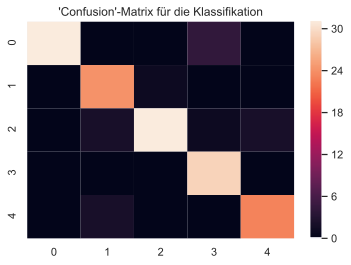

In [33]:
ARCHITECTURE = [256, 32]

(accuracy, confusion, history) = train_and_test_dense_net(100, ARCHITECTURE)
print("Genauigkeit: ", accuracy)
_ = sns.heatmap(confusion).set(title="'Confusion'-Matrix für die Klassifikation")

Das zusätzliche History-Objekt enthält Informationen über den Verlauf des Trainings, die wir wie folgt visualisieren:

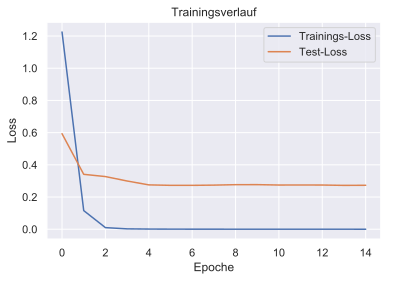

In [35]:
def plot_losses(history):
    loss_dF = pd.DataFrame({"Trainings-Loss": history.history["loss"],
                            "Test-Loss": history.history["val_loss"]})
    loss_dF.plot.line().set(xlabel="Epoche", ylabel="Loss", title="Trainingsverlauf")

plot_losses(history)

Das Bild zeigt den Verlauf der Loss-Funktion nach jeder Epoche des Trainings. Genauer sehen wir
die Kreuzentropie zwischen den Vorhersagen und den tatsächlichen one-hot-kodierten Labels
- für die Trainingsdaten (`loss`) und
- für die Testdaten (`val_loss`).

Wir sehen, dass die Loss-Funktion  sehr schnell erfolgreich minimiert wurde - aber nur auf den Trainingsdaten! Das Netz kann das Gelernte offenbar schlecht auf die Testdaten übertragen. Sinkt die Genauigkeit der Vorhersage mit fortschreitendem Training sogar wieder, so spricht man von [Überanpassung/Overfitting](https://de.wikipedia.org/wiki/%C3%9Cberanpassung). Diese tritt stets dann ein, wenn man zu wenig oder nicht repräsentative Trainingsdaten hat.

### Mit Dropout die Genauigkeit verbessern

Wie können wir die Leistung des Modells verbessern? Ein gutes Mittel lautet [Dropout](https://de.wikipedia.org/wiki/Dropout_(k%C3%BCnstliches_neuronales_Netz)) &mdash; bei jedem Lernschritt wird ein Teil der Neuronen "ausgeblendet". In `keras` erreicht man dies durch zusätzliche _Dropout-Schichten_. Diese werden zwischen die gewöhnlichen Schichten eingefügt und erhalten als Parameter die _Dropout-Rate_, die angibt, welcher Prozentsatz der Neuronen in der vorherigen Schicht "ausgeblendet" werden sollen. Unsere Routine `build_seq_model` fügt immer dann eine Dropout-Schicht ein, wenn der Größen-Parameter für die aktuelle Schicht kleiner 1 ist.

Train on 350 samples, validate on 150 samples
Epoch 1/15
350/350 [==============================] - 1s 4ms/step - loss: 1.3658 - val_loss: 0.8586
Epoch 2/15
350/350 [==============================] - 1s 3ms/step - loss: 0.3849 - val_loss: 0.4800
Epoch 3/15
350/350 [==============================] - 1s 3ms/step - loss: 0.0790 - val_loss: 0.3303
Epoch 4/15
350/350 [==============================] - 1s 3ms/step - loss: 0.0338 - val_loss: 0.3340
Epoch 5/15
350/350 [==============================] - 1s 3ms/step - loss: 0.0126 - val_loss: 0.3863
Epoch 6/15
350/350 [==============================] - 1s 3ms/step - loss: 0.0085 - val_loss: 0.3230
Epoch 7/15
350/350 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.2907
Epoch 8/15
350/350 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.2808
Epoch 9/15
350/350 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.2699
Epoch 10/15
350/350 [==============================] -

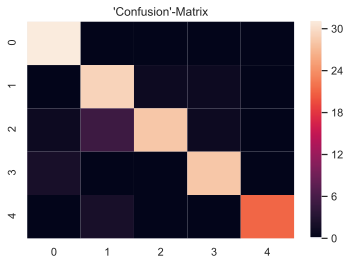

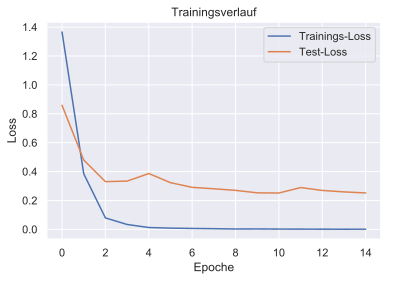

In [36]:
(accuracy, confusion, history) = train_and_test_dense_net(100, [256, 0.5, 32],
                                                      epochs=15)
print("Genauigkeit: ", accuracy)
sns.heatmap(confusion).set(title="'Confusion'-Matrix")
plot_losses(history)

Die Technik funktioniert: zwar sinkt die Trainings-Kreuzentropie langsamer, aber dafür auch die Test-Kreuzentropie länger beziehungsweise tiefer.

### Das Experiment

Zum Abschluss lassen wir den Rechner nochmal schnaufen und testen, wie sehr die Netz-Architektur, die Dropout-Rate und die zufällige Auswahl der Reden das Testergebnis beeinflussen.

In [37]:
def neural_experiment(train_and_test_fn, num_samples, rounds, architectures, epochs):
    losses = dict()
    accuracies = dict()
    for architecture in architectures:
        print("Testdurchlauf für Netzarchitektur ", architecture)
        for rnd in range(rounds):
            print("Runde ", rnd + 1, "/", rounds)
            (accuracy, _, history) = train_and_test_fn(num_samples, 
                                                       architecture=architecture, 
                                                       epochs=epochs)
            losses[(str(architecture), "Trainings-Loss", rnd)] = history.history["loss"]
            losses[(str(architecture), "Test-Loss", rnd)] = history.history["val_loss"]
            accuracies[(str(architecture), rnd)] = accuracy
    return (pd.DataFrame(accuracies, index=[0]),
            pd.DataFrame(losses, index=range(0, epochs)).rename_axis("Epoche"))

Das folgende Experiment kann je nach Rechner eine ganze Weile dauern. Wieder Zeit für einen Kaffee? Für den Fall, dass nicht, haben wir die Ergebnisse bereits grafisch aufbereitet &mdash; einfach die folgende Zelle überspringen.

In [ ]:
ARCHITECTURES = [[256, 64, 16], [256, 64, 0.5, 16],
                 [256, 32], [256, 0.5, 32],  
                 [1024, 0.3, 64], [1024, 0.7, 64]]

(accuracies, losses) = neural_experiment(train_and_test_dense_net, 
                                         num_samples=100, rounds=10, 
                                         architectures=ARCHITECTURES, epochs=10)
accuracies.to_pickle("dense_accuracies.pickle")
losses.to_pickle("dense_losses.pickle")

Die folgende Grafik zeigt, wie für jede Netzwerk-Architektur die Genauigkeit in den jeweiligen Durchläufen streut.

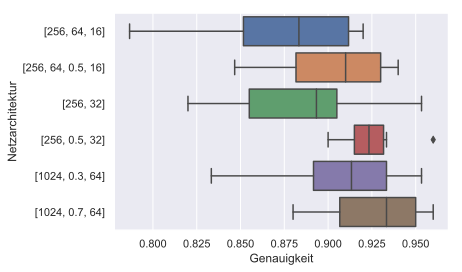

In [39]:
import seaborn as sns
%matplotlib inline

accuracies = pd.read_pickle("dense_accuracies.pickle")

def plot_net_accuracies(accuracies):
    acc_long = accuracies.melt(var_name=["Netzarchitektur", "Runde"], value_name="Genauigkeit")
    sns.boxplot(y="Netzarchitektur", x="Genauigkeit", data=acc_long)
    
plot_net_accuracies(accuracies)

Die Vereinfachung der Netz-Architektur verbessert nicht nur die Genauigkeiten, sondern reduziert auch die Streuung. Außerdem verbessert Dropout jeweils deutlich die Ergebnisse.

Zum Schluss betrachten wir noch, wie sich Trainings-Loss und Validierungs-Loss während des Lernprozesses entwickelt haben.

/Users/timmermann/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


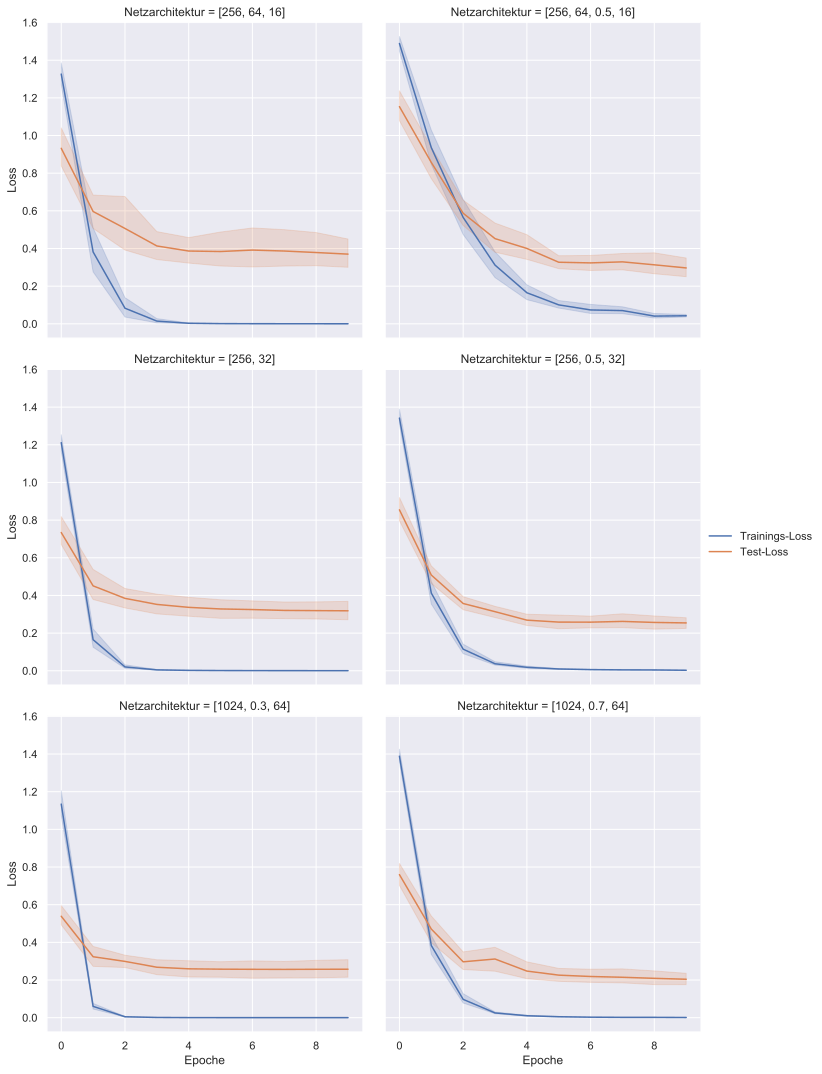

In [40]:
losses = pd.read_pickle("dense_losses.pickle")

def plot_losses(losses):
    loss_long = losses.reset_index().melt(id_vars="Epoche", 
                                          var_name=["Netzarchitektur", "",
                                                    "Runde"],
                                          value_name="Loss")
    sns.relplot(x="Epoche", hue="", col="Netzarchitektur", col_wrap=2, 
                y="Loss", data=loss_long, kind="line")
    
plot_losses(losses)

## Wort-Einbettungen

### Einführung

Bisher haben wir für die Klassifikation nur statistische Informationen über die Token, Wortstämme beziehungsweise named entitites genutzt. Wo beziehungsweise in welcher Reihenfolge diese in der Rede auftraten, spielte keine Rolle. Durch unsere statistische Brille betrachtet könnten wir also die beiden Sätze
    
    "Ich bin Gargamel und hasse Papa Schlumpf."
    
und

    "Ich bin Papa Schlumpf und hasse Gargamel."
    
nicht unterscheiden! Für manche Anwendungen von NLP ist das in Ordnung, aber für manche muss man den Text als eine Folge von Token darstellen. 

Für die Anwendung von machine learning oder deep learning müssen wir die Token, die bisher Zeichenketten sind, durch Zahlen beziehungsweise Vektoren darstellen. Die Frage ist, wie:

1. Ein erster Ansatz wäre: _einfach durchnummerieren_. Das Problem dabei: (fast) alle Algorithmen würden Token mit nahe beieinander liegenden Nummern als ähnlich ansehen.
2. Eine bessere Idee: _one-hot-kodieren_, wie wir das bereits mit den Labeln gemacht haben. 
Das Problem hierbei: für jedes Token erhalten wir einen Vektor mit hunderttausenden oder mehr Komponenten  - je nachdem, wie groß unser Vokabular ist. Bei solchen Eingaben versagen alle bekannten Algorithmen, und zwar nicht nur aufgrund des Rechenaufwandes, sondern prinzipiell (siehe [Fluch der hohen Dimensionen](https://de.wikipedia.org/wiki/Fluch_der_Dimensionalit%C3%A4t)).
3. Die übliche Lösung: wir verwenden eine _spezielle dichte Einbettung_, englisch _word embedding_, die jedem Wort einen Vektor zuordnet, der mehrere Hundert Komponenten hat, aber nicht hunderttausend oder mehr wie im Ansatz 2.

Doch woher kann man solch eine dichte Einbettung nehmen? Die wichtigsten Algorithmen, die solche Einbettungen aus einem riesigen Textvorrat (wie etwa Wikipedia-Seiten) berechnen, sind [word2vec](https://en.wikipedia.org/wiki/Word2vec) und [gloVe](https://nlp.stanford.edu/projects/glove/). Für die englische Sprache ist solch eine Einbettung in [spacy](https://www.spacy.io) verfügbar, für Deutsch und sehr viele weitere Sprachen zum Beispiel in [fasttext](https://fasttext.cc). Wir greifen hier auf eine [Arbeit](https://devmount.github.io/German_word_embeddings/) von [Andreas Müller](https://github.com/devmount) zurück.

_Achtung:_ Die benötigte Datei mit den deutschen Worteinbettungen ist _sehr_ groß (704 MB). Das folgende Herunterladen ist deswegen zunächst auskommentiert.

In [ ]:
WV_PATH = "data/german.model"
WV_DIM = 300

import urllib

def fetch_embedding(): 
    if not os.path.isfile(WV_PATH):
        WV_URL = "http://cloud.devmount.de/d2bc5672c523b086"
        urllib.request.urlretrieve(WV_URL, WV_PATH)

fetch_embedding()

Die Wort-Einbettungen wurden mit Hilfe der Bibliothek [gensim](https://radimrehurek.com/gensim/) erstellt, die viele interessante Funktionen für NLP in Python bereitstellt.

In [ ]:
import gensim

w2v = gensim.models.KeyedVectors.load_word2vec_format(WV_PATH, binary=True)

Was ist an Wort-Einbettungen so spannend und verblüffend? Sowohl der Abstand als auch die Addition und Subtraktion von Vektoren sind erstaunlich "sinnvoll". So kann man mit Wort-Einbettungen Tabu spielen! _Achtung:_ für `w2v` müssen die Buchstaben `ä`, `ö`, `ü`, `ß` durch `ae`, `oe`, `ue`, `ss` ersetzt werden.

In [ ]:
TABU_AUFGABEN = [["Deutschland", "Kontinent"],
                 ["Jahreszeit", "Schnee", "Sommer"],
                 ["Stuhl", "Gemuetlich"],
                 ["Fest", "Winter", "Christkind"],
                ]

def tabu(aufgaben=TABU_AUFGABEN):
    for woerter in aufgaben: 
        antwort, sicherheit = w2v.most_similar(woerter, topn=1)[0]
        print(" + ".join(woerter), "=>",  antwort, "(%f)" % sicherheit)
        
tabu()

Die Antworten sind gar nicht so schlecht, oder?

Interessant ist auch, sich eine Projektion mehrerer Wortvektoren in der Ebene anzuschauen. Eine geeignete Projektionsebene wählen wir mit Hilfe einer [Hauptkomponentenanalyse/principal component analysis](https://de.wikipedia.org/wiki/Hauptkomponentenanalyse).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

WORTLISTE = ["Mutter", "Tochter", "Sohn", "Opa", "Oma", 
             "Vater", "Grossvater", "Grossmutter"]

def plot_word_vectors(woerter=WORTLISTE):
    pca = PCA(n_components=2)
    coords = pca.fit_transform(np.vstack([w2v[w] for w in woerter]))
    plt.axis((-1.5,2.5,-1.5,1.5))
    plt.scatter(coords[:,0], coords[:,1])
    for (i, w) in enumerate(woerter):
        plt.annotate(w, xy=coords[i] + (0.05,0.05))
    plt.title("Wortvektoren kodieren Semantik")
        
plot_word_vectors()

### Klassifikation

Nun wollen wir schließlich noch eine Klassifikation mit Hilfe der Worteinbettungen trainieren. 

Dazu nehmen wir von jeder Rede die ersten `SAMPLE_LEN` Token, schreiben deren jeweilige Wortvektoren nebeneinander in ein 2-dimensionales numpy-Array und verwenden dieses Array als Darstellung der Rede für die Klassifikation. Dabei müssen wir bei den Token Umlaute ersetzen und die Wörter groß schreiben. Zur Kontrolle notieren wir auch, für welche Token `w2v` _keinen_ Wortvektor enthält.

In [ ]:
SAMPLE_LEN = 800
WV_DIM = 300
def replace(text):
    """
    Replaces german umlauts and sharp s in given text. Uppercase first letter.
    :param text: text as str
    :return: manipulated text as str
    """
    res = text
    res = res.replace('ä', 'ae')
    res = res.replace('ö', 'oe')
    res = res.replace('ü', 'ue')
    res = res.replace('Ä', 'Ae')
    res = res.replace('Ö', 'Oe')
    res = res.replace('Ü', 'Ue')
    res = res.replace('ß', 'ss')
    return res[0].upper() + res[1:]


def wvseq(speech, sample_len=SAMPLE_LEN):
    vectors = np.zeros((sample_len, WV_DIM))
    (j, t, misses) = (0, 0, []) 
    for (j,token) in zip(range(0,sample_len), speech):
        tok = replace(token)
        if tok in w2v:
            vectors[j] = w2v[tok]
        else:
            misses.append(token)
    return (vectors, misses)

In [ ]:
speech = ["Hallo", "das", "ist", "interessanterweise", "XYZ", "unklar", "!"]
(vectors, misses) = wvseq(speech, len(speech))
misses

Nun wenden wir diese Vorverarbeitung auf unsere Reden an und prüfen, welcher Prozentsatz an Token in `w2v` fehlt.

In [ ]:
wvs_misses = df.tokens.map(wvseq)
df["word_vectors"] = wvs_misses.map(lambda x: x[0])
df["miss_cnt"] = wvs_misses.map(lambda x: len(x[1])/SAMPLE_LEN)
_ = sns.boxenplot(df.miss_cnt).set(xlabel="", title="Anteil fehlender Token unter den jeweils %d ersten Token der Reden" % NUM_SAMPLES)

Wir verwenden nun die vorverarbeiteten Daten zur Klassifikation mit Hilfe eines kombinierten neuronalen Netzwerks, dessen erste Schicht eine 1-dimensionale Faltung durchführt, 

In [ ]:
EPOCHS = 25

def build_conv_model(architecture, y_dim):
    model = Sequential()
    ((num_channels, kernel_size), pooling, dropout, layer_size) = architecture
    model.add(layers.Conv1D(num_channels, kernel_size, activation="relu", 
                            input_shape=(SAMPLE_LEN, WV_DIM)))
    model.add(layers.MaxPooling1D(pooling))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(layer_size, activation="relu"))
    model.add(layers.Dense(y_dim, activation="softmax"))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy')
    return model


def train_and_test_conv_net(num_samples, architecture, epochs=EPOCHS):
    sampled_df = sample_speeches(df, num_samples)
    labels = sampled_df["person"].astype("category").cat.codes
    data = np.stack(sampled_df.word_vectors.values)
    model = build_conv_model(architecture, np.max(labels) + 1)
    return train_and_test_net(model, data, labels, epochs)

Bereit für einen Testlauf?

In [ ]:
ARCHITECTURE = ((64, 8), 8, 0.8, 128)

(acc, cm, hist) = train_and_test_conv_net(100, architecture=ARCHITECTURE)     
acc

Das Ergebnis ist nicht so berauschend, wenn man bedenkt, dass wir vorher schon eine durchschnittliche Genauigkeit über 90 Prozent erzielt hatten. Andererseits verwenden wir nun von jeder Rede nur die ersten 400 Token (beziehungsweise rund 320 Token, wenn man bedenkt, dass einige nicht in `w2v` enthalten sind). 

### Das Experiment

Ähnlich wie vorher werfen wir noch einen Blick auf die Streuung der Genauigkeit, die sich aus der zufälligen Auswahl an Trainings- und Testreden ergibt, und testen verschiedene Netz-Parameter.

In [ ]:
ARCHITECTURES = [((64, 8), 8, 0.5, 64), ((32, 8), 8, 0.8, 64), ((128, 8), 8, 0.8, 128)]

(accuracies, losses) = neural_experiment(train_and_test_conv_net, num_samples=100, rounds=10, 
                                         architectures=ARCHITECTURES, epochs=30)

accuracies.to_pickle("conv_accuracies.pickle")
losses.to_pickle("conv_losses.pickle")

Hier die Genauigkeiten und die Lernverläufe noch einmal visualisiert. Wie zuvor beobachten wir eine Überanpassung.

In [ ]:
accuracies = pd.read_pickle("ft-conv_accuracies.pickle")
losses = pd.read_pickle("ft-conv_losses.pickle")
plot_net_accuracies(accuracies)
plot_losses(losses)

## Auf Wiedersehen!

Wir hoffen, dass Dir das experimentieren Spaß gemacht hat! Komm bald wieder zum codecentric.ai bootcamp!